# Quick start and general recommendations
This notebook provides a brief introduction to `bayes_drt` and general recommendations for best results. For more detail, see the in-depth tutorials.

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib notebook
import glob

from bayes_drt.inversion import Inverter
from bayes_drt import eis_utils as gt

%load_ext autoreload
%autoreload 2

In [2]:
# set plotting params and data directory
datadir = '../data'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

# Fitting the DRT

This example demonstrates the basic process of fitting the distribution of relaxation times (DRT) to impedance data and anlayzing the results:  
* Apply `map_fit` and/or `bayes_fit` to fit the DRT
* Evaluate the recovered DRT using `predict_distribution`
* Evaluate the impedance fit using `predict_Z`
* Evaluate the recovered error structure using `predict_sigma`
* Evaluate the polarization resistance and offsets using `predict_Rp`, `R_inf`, and `inductance`

This example uses data simulated with noise from an equivalent circuit model consisting of an RC element and a ZARC element in series.

In [61]:
"Load data"
# load simulated impedance data with noise
Z_file = os.path.join(datadir,'simulated','Z_RC-ZARC_Macdonald_0.25.csv')
Zdf = pd.read_csv(Z_file)

# load true DRT
g_file = os.path.join(datadir,'simulated','gamma_RC-ZARC.csv')
g_true = pd.read_csv(g_file)

# extract frequency and complex impedance
freq = Zdf['Freq'].values
Z = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values

In [62]:
"Fit the data"
# by default, the Inverter class is configured for the DRT
# inv_hmc = Inverter()
inv_map = Inverter()

# Perform HMC fit
start = time.time()
inv_hmc.bayes_fit(freq,Z)
elapsed = time.time() - start
print('HMC fit time {:.2f}'.format(elapsed))

# Perform MAP fit
start = time.time()
inv_map.map_fit(freq,Z)
elapsed = time.time() - start
print('MAP fit time {:.2f}'.format(elapsed))

HMC fit time 50.27
MAP fit time 1.16


`map_fit` is about 50 times faster than `bayes_fit` for this spectrum.

<IPython.core.display.Javascript object>


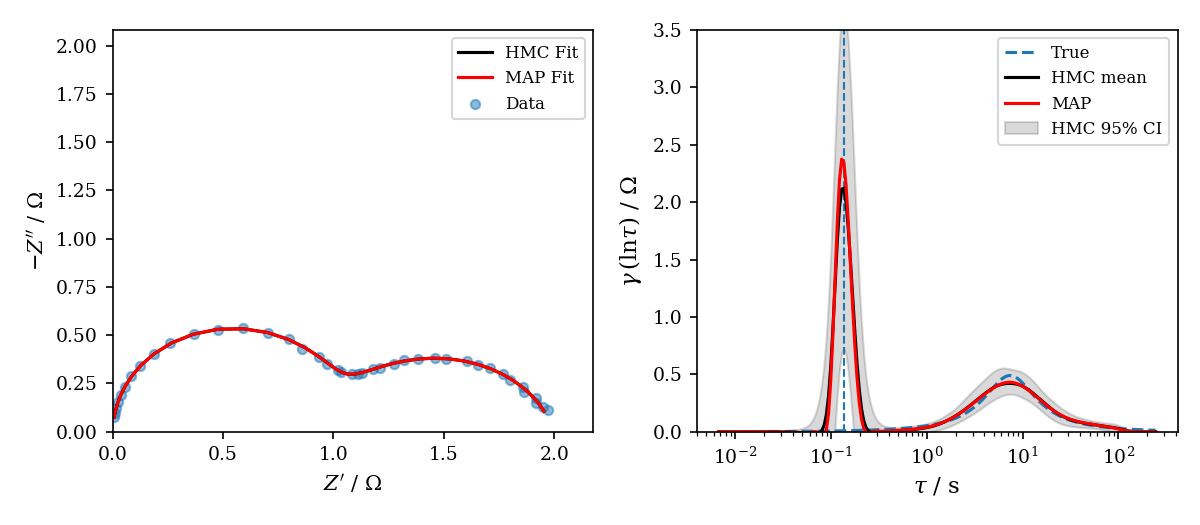

In [63]:
"Visualize DRT and impedance fit"
# plot impedance fit and recovered DRT
fig,axes = plt.subplots(1,2,figsize=(8,3.5))

# plot impedance data
gt.plot_nyquist(Zdf,ax=axes[0],s=20,alpha=0.5,label='Data')

# plot model fit of impedance
Z_hmc = inv_hmc.predict_Z(freq)
Z_map = inv_map.predict_Z(freq)
df_hmc = gt.construct_eis_df(freq,Z_hmc)
df_map = gt.construct_eis_df(freq,Z_hmc)
gt.plot_nyquist(df_hmc,ax=axes[0],plot_func='plot',c='k',label='HMC Fit')
gt.plot_nyquist(df_map,ax=axes[0],plot_func='plot',c='r',label='MAP Fit')

# plot true DRT
p = axes[1].plot(g_true['tau'],g_true['gamma'],label='True',ls='--')
# add Dirac delta function for RC element
axes[1].plot([np.exp(-2),np.exp(-2)],[0,10],ls='--',c=p[0].get_color(),lw=1)

# evaluate recovered DRT at given tau values
tau_plot = g_true['tau'].values
g_hmc = inv_hmc.predict_distribution('DRT',tau_plot)
g_map = inv_map.predict_distribution('DRT',tau_plot)
# plot recovered DRT
axes[1].plot(tau_plot,g_hmc,c='k',label='HMC mean')
axes[1].plot(tau_plot,g_map,c='r',label='MAP')

# get DRT credible interval from HMC fit
g_lo = inv_hmc.predict_distribution('DRT',tau_plot,percentile=2.5)
g_hi = inv_hmc.predict_distribution('DRT',tau_plot,percentile=97.5)
axes[1].fill_between(tau_plot,g_lo,g_hi,color='k',alpha=0.15,label='HMC 95% CI')


axes[1].set_xscale('log')
axes[1].set_ylim(0,3.5)
axes[1].legend()
axes[1].set_xlabel(r'$\tau$ / s')
axes[1].set_ylabel(r'$\gamma \, (\ln{\tau})$ / $\Omega$')

fig.tight_layout()

The HMC result produces a distribution, which is visualized above using both the mean (black line) and the 95% credible interval (CI, gray region). The HMC mean lies precisely underneath the MAP estimate over most of the $\tau$ range in the above DRT plot. The HMC and MAP fits produce virtually identical impedance fits.

<IPython.core.display.Javascript object>


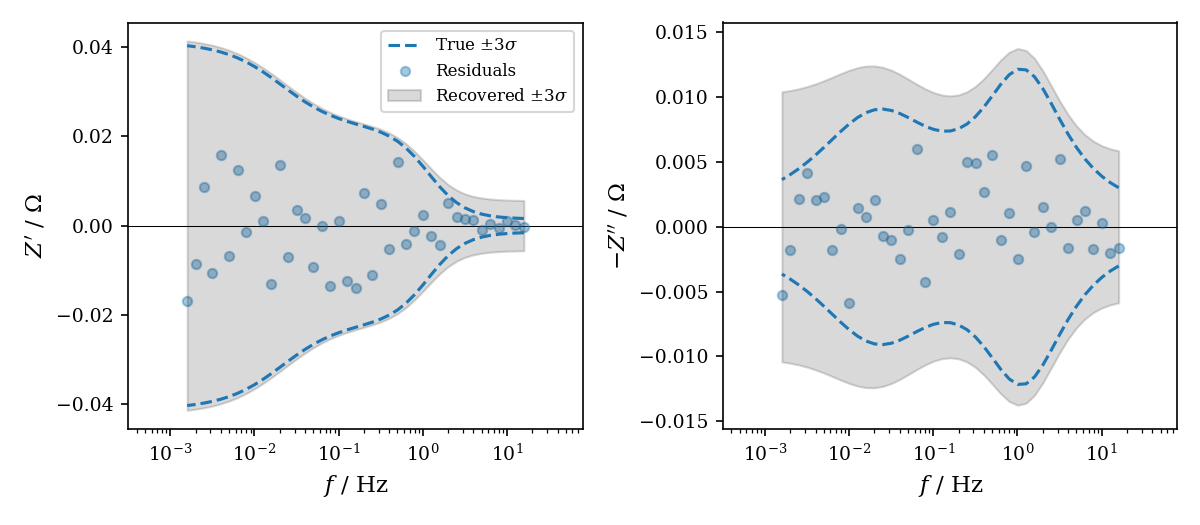

In [66]:
"Visualize the recovered error structure"
# For visual clarity, only HMC results are shown.
# MAP results can be obtained in the same way
fig,axes = plt.subplots(1,2,figsize=(8,3.5),sharex=True)

# plot residuals
Z_pred = inv_hmc.predict_Z(freq)
df_err = gt.construct_eis_df(freq,Z_pred-Z)
gt.plot_bode(df_err,axes=axes,cols=['Zreal','Zimag'],alpha=0.4,s=20,label='Residuals',unit_scale='')

# plot true error scale
p = axes[0].plot(freq,3*Zdf['sigma_re'],ls='--',label='True $\pm 3\sigma$')
axes[0].plot(freq,-3*Zdf['sigma_re'],ls='--',c=p[0].get_color())
axes[1].plot(freq,3*Zdf['sigma_im'],ls='--')
axes[1].plot(freq,-3*Zdf['sigma_im'],ls='--',c=p[0].get_color())

# plot zero line
for ax in axes:
    ax.axhline(0,c='k',lw=0.5,zorder=-10)

# get the recovered error scale
sigma_re, sigma_im = inv_hmc.predict_sigma(freq)
# plot recovered error scale
axes[0].fill_between(freq,-3*sigma_re,3*sigma_re,color='k',alpha=0.15,label='Recovered $\pm3\sigma$')
axes[1].fill_between(freq,-3*sigma_im,3*sigma_im,color='k',alpha=0.15)

axes[0].legend()

fig.tight_layout()

The recovered error structure is fairly accurate; it slightly overpredicts the imaginary error scale.

In [67]:
"Get the polarization resistance, ohmic resistance, and inductance"
# Results are shown for HMC only, but can be obtained for the MAP fit in the same way.
# The only difference is that the MAP fit does not provide percentile prediction.
print('R_inf: {:.4f} ohms'.format(inv_hmc.R_inf))
print('Inductance: {:.4e} H'.format(inv_hmc.inductance))
print('Polarization resistance: {:.4f} ohms'.format(inv_hmc.predict_Rp()))
print('Rp 2.5 percentile: {:.4f} ohms'.format(inv_hmc.predict_Rp(percentile=2.5)))
print('Rp 97.5 percentile: {:.4f} ohms'.format(inv_hmc.predict_Rp(percentile=97.5)))

R_inf: 0.0016 ohms
Inductance: 1.0979e-05 H
Polarization resistance: 1.9802 ohms
Rp 2.5 percentile: 1.9729 ohms
Rp 97.5 percentile: 1.9874 ohms


The true values for $R_\infty$, $L$, and $R_p$ are 0 $\Omega$, 0 H, and 2 $\Omega$, respectively. The estimates for $R_\infty$ and $R_p$ are accurate, but the inductance estimate is somewhat high. However, because the measured frequency range captures only relatively low frequencies, inductive effects are hard to estimate.

# Fitting the DDT
This example demonstrates recovery of the distribution of diffusion times (DDT, see https://doi.org/10.1103/PhysRevLett.120.116001). The process is identical to the DRT fitting process, except that the desired distribution must be defined explicitly when creating the `Inverter` object. For this example, we use data simulated with noise from a bimodal DDT with transmissive boundary conditions and planar symmetry.

In [112]:
"Load data"
# load simulated impedance data with noise
Z_file = os.path.join(datadir,'simulated','Z_BimodalTP-DDT_Orazem_0.25.csv')
Zdf = pd.read_csv(Z_file)

# load true DDT
g_file = os.path.join(datadir,'simulated','gamma_BimodalTP-DDT.csv')
g_true = pd.read_csv(g_file)

# extract frequency and complex impedance
freq = Zdf['Freq'].values
Z = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values

In [120]:
"Fit the data"
# Define the distribution to be recovered (transmissive planar DDT) in the Inverter initialization
# Use a slightly expanded basis frequency range to fully capture the tail of the low-frequency peak
inv_hmc = Inverter(distributions={'DDT':{'kernel':'DDT','dist_type':'parallel','bc':'transmissive',
                                         'symmetry':'planar','basis_freq':np.logspace(6,-3,91)}
                                 }
                  )
inv_map = Inverter(distributions={'DDT':{'kernel':'DDT','dist_type':'parallel','bc':'transmissive',
                                         'symmetry':'planar','basis_freq':np.logspace(6,-3,91)}
                                 }
                  )

# Perform HMC fit
start = time.time()
inv_hmc.bayes_fit(freq,Z)
elapsed = time.time() - start
print('HMC fit time {:.2f}'.format(elapsed))

# Perform MAP fit
start = time.time()
inv_map.map_fit(freq,Z)
elapsed = time.time() - start
print('MAP fit time {:.2f}'.format(elapsed))

c:\users\jdh10\onedrive - colorado school of mines\python\projects\bayes_drt\bayes_drt\inversion.py:2367: RuntimeWarning: overflow encountered in tanh
  else:
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


HMC fit time 86.86
MAP fit time 1.52


`map_fit` is again about 50 times faster than `bayes_fit` for this spectrum.

<IPython.core.display.Javascript object>


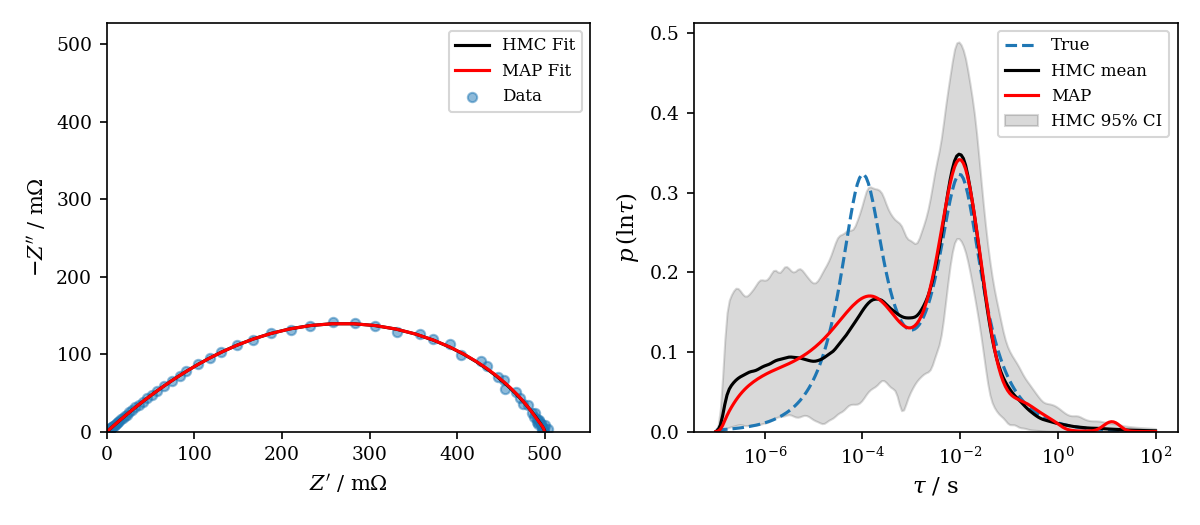

In [138]:
"Visualize DRT and impedance fit"
# plot impedance fit and recovered DRT
fig,axes = plt.subplots(1,2,figsize=(8,3.5))

# plot impedance data
gt.plot_nyquist(Zdf,ax=axes[0],s=20,alpha=0.5,label='Data')

# plot model fit of impedance
Z_hmc = inv_hmc.predict_Z(freq)
Z_map = inv_map.predict_Z(freq)
df_hmc = gt.construct_eis_df(freq,Z_hmc)
df_map = gt.construct_eis_df(freq,Z_map)
gt.plot_nyquist(df_hmc,ax=axes[0],plot_func='plot',c='k',label='HMC Fit')
gt.plot_nyquist(df_map,ax=axes[0],plot_func='plot',c='r',label='MAP Fit')

# plot true DRT
p = axes[1].plot(g_true['tau'],g_true['gamma'],label='True',ls='--')

# evaluate recovered DDT at given tau values
tau_plot = g_true['tau'].values
g_hmc = inv_hmc.predict_distribution('DDT',tau_plot)
g_map = inv_map.predict_distribution('DDT',tau_plot)
# plot recovered DRT
axes[1].plot(tau_plot,g_hmc,c='k',label='HMC mean')
axes[1].plot(tau_plot,g_map,c='r',label='MAP')

# get DDT credible interval from HMC fit
g_lo = inv_hmc.predict_distribution('DDT',tau_plot,percentile=2.5)
g_hi = inv_hmc.predict_distribution('DDT',tau_plot,percentile=97.5)
axes[1].fill_between(tau_plot,g_lo,g_hi,color='k',alpha=0.15,label='HMC 95% CI')


axes[1].set_xscale('log')
axes[1].legend()
axes[1].set_ylim(0,axes[1].get_ylim()[1])
axes[1].set_xlabel(r'$\tau$ / s')
axes[1].set_ylabel(r'$p \, (\ln{\tau})$')

fig.tight_layout()

The recovered DDT accurately captures the long-timescale peak, but recovers the short-timescale peak relatively poorly. While these results are suboptimal, this seems to be typical for DDT recovery - features at shorter timescales are often poorly recovered because they have less influence on the impedance. This result actually compares favorably to results using other DDT recovery methods.

<IPython.core.display.Javascript object>


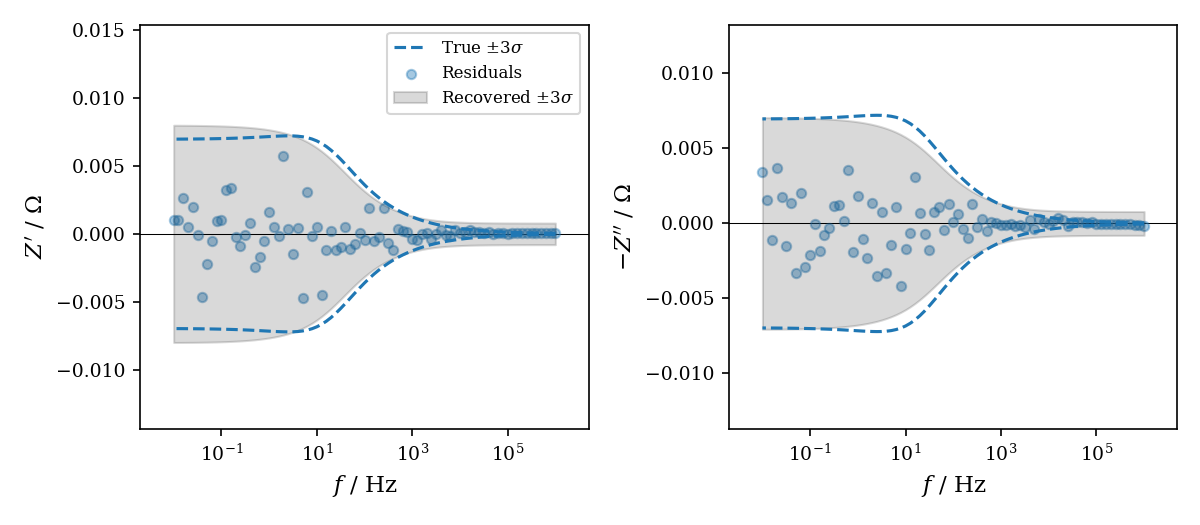

In [139]:
"Visualize the recovered error structure"
# For visual clarity, only HMC results are shown.
# MAP results can be obtained in the same way
fig,axes = plt.subplots(1,2,figsize=(8,3.5),sharex=True)

# plot residuals
Z_pred = inv_hmc.predict_Z(freq)
df_err = gt.construct_eis_df(freq,Z_pred-Z)
gt.plot_bode(df_err,axes=axes,cols=['Zreal','Zimag'],alpha=0.4,s=20,label='Residuals',unit_scale='')

# plot true error scale
p = axes[0].plot(freq,3*Zdf['sigma_re'],ls='--',label='True $\pm 3\sigma$')
axes[0].plot(freq,-3*Zdf['sigma_re'],ls='--',c=p[0].get_color())
axes[1].plot(freq,3*Zdf['sigma_im'],ls='--')
axes[1].plot(freq,-3*Zdf['sigma_im'],ls='--',c=p[0].get_color())

# plot zero line
for ax in axes:
    ax.axhline(0,c='k',lw=0.5,zorder=-10)

# get the recovered error scale
sigma_re, sigma_im = inv_hmc.predict_sigma(freq)
# plot recovered error scale
axes[0].fill_between(freq,-3*sigma_re,3*sigma_re,color='k',alpha=0.15,label='Recovered $\pm3\sigma$')
axes[1].fill_between(freq,-3*sigma_im,3*sigma_im,color='k',alpha=0.15)

axes[0].legend()

fig.tight_layout()

The recovered error structure is again fairly accurate.

In [140]:
"Get the polarization resistance, ohmic resistance, and inductance"
# Results are shown for HMC only, but can be obtained for the MAP fit in the same way.
# The only difference is that the MAP fit does not provide percentile prediction.
print('R_inf: {:.4f} ohms'.format(inv_hmc.R_inf))
print('Inductance: {:.4e} H'.format(inv_hmc.inductance))
print('Polarization resistance: {:.4f} ohms'.format(inv_hmc.predict_Rp()))
print('Rp 2.5 percentile: {:.4f} ohms'.format(inv_hmc.predict_Rp(percentile=2.5)))
print('Rp 97.5 percentile: {:.4f} ohms'.format(inv_hmc.predict_Rp(percentile=97.5)))

R_inf: 0.0000 ohms
Inductance: 2.2885e-11 H
Polarization resistance: 0.4999 ohms
Rp 2.5 percentile: 0.4984 ohms
Rp 97.5 percentile: 0.5014 ohms


c:\users\jdh10\onedrive - colorado school of mines\python\projects\bayes_drt\bayes_drt\inversion.py:2380: RuntimeWarning: overflow encountered in tanh
  if part=='real':


The estimates for $R_\infty$, $L$, and $R_p$ are very accurate - the true values are 0 $\Omega$, 0 H, and 0.5 $\Omega$, respectively.

# Fitting multiple distributions
It is also possible to fit multiple distributions simultaneously. For example, an impedance spectrum may arise from a relaxation process in series with a diffusive process; we would want to fit this spectrum using both a DRT and a DDT. This is a more involved process and is thus not covered here. See the detailed tutorial on multi-distribution recovery.

# General recommendations

* **Use `map_fit` for fast, accurate results.** It typically runs an order of magnitude faster than `bayes_fit` with comparable results, and is great for testing things before investing the time in `bayes_fit`.
* **Run `map_fit` and `bayes_fit` with `nonneg_drt=False` (the default) for best stability** (unless you are performing a multi-distribution fit, as noted below). These methods are generally robust to undesired zero crossings, and tend to produce good results without a constraint on the sign of the DRT. Enforcing a non-negativity constraint is usually unnecessary and in some cases may cause sampling/optimization issues.
* **If the impedance response is truncated (i.e. you can only see a partial semicircle/arc in the Nyquist plot), use an expanded basis frequency range to capture the full DRT.** If you use too small of a range, the model will not be able to fit the data. See the Extrapolation tutorial for an example.
* **If you're using a custom basis frequency range, make sure to use a spacing of 10 points per decade (ppd) for best results**, even if the measurement has a different data density. The model is calibrated for a 10 ppd mesh and may produce unexpected results with different spacings.
* **Reuse the same `Inverter` instance to run multiple fits with the same measurement and basis frequencies.** This will save you some time on matrix calculations.
* **Pickle `Inverter` instances to maintain full access to fit results.** You can unpickle the instance later and use all the built-in methods and attributes to analyze your data without having to re-run fits. The `stan_models` module provides `save_pickle` and `load_pickle` methods that work well for this purpose.
* **Use DDT and multi-distribution recovery with caution.** These features are still somewhat experimental and may not behave as expected in all cases. Multi-distribution fitting seems to work best with `nonneg_drt=True`.

If you encounter any problems, please feel free to report an issue or reach out. Happy fitting!